# Predict low, high strategy  EDA

To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
# Downloading latest bots data
os.system("cd ./../deploy/yandex_cloud; ./bots_get_data.sh")

rsync -v -r yc-user@84.201.128.116:/home/yc-user/biml/data/ /home/dima/projects/biml/deploy/yandex_cloud/../../data/yandex-cloud
receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-05-10_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-05-10_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-05-10_BTCUSDT_y.csv
LSTMStrategy/Xy/2023-05-11_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-05-11_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-05-11_BTCUSDT_y.csv
LSTMStrategy/weights/2023-05-11T07:25:14.313107.data-00000-of-00001
LSTMStrategy/weights/2023-05-11T07:25:14.313107.index
LSTMStrategy/weights/checkpoint

sent 163,593 bytes  received 1,922,195 bytes  78,708.98 bytes/sec
total size is 140,752,534  speedup is 67.48


0

Init binance client

In [3]:
from binance.spot import Spot as Client
import os
import sys
import yaml

# Load 
def load_config():
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    # Defaults
    cfg_dir="./../biml/cfg"
    default_cfg_path = f"{cfg_dir}/app-defaults.yaml"
    with open(default_cfg_path, "r") as appdefaults:
        config = yaml.safe_load(appdefaults)

    # Custom config, should contain custom information,
    cfg_path = f"{cfg_dir}/app.yaml"
    if os.path.exists(cfg_path):
        with open(cfg_path) as app:
            config.update(yaml.safe_load(app))
    else:
        sys.exit(
            f"Config {cfg_path} not found. Please copy cfg/app-defaults.yaml to {cfg_path} "
            f"and update connection info there.")

    # Enviroment variabless
    config.update(os.environ)
    return config

def load_config_yc():
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    project_dir="./.."
    # Defaults
    cfg_path = f"{project_dir}/deploy/yandex_cloud/secret/app.yaml"
    with open(cfg_path, "r") as appdefaults:
        config = yaml.safe_load(appdefaults)
    return config

def create_client(strategy: str):
        # Create binance client
        config=load_config()
        # Uncomment if we are analysing bot from yandex cloud
        config.update(load_config_yc())
        
        strategy=strategy.lower()
        key,secret,url=config[f"biml.connector.{strategy}.key"],config[f"biml.connector.{strategy}.secret"],config["biml.connector.url"]
        return Client(key=key, secret=secret, base_url=url, timeout=10)

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"

client = create_client(strategy)



## Account and orders

In [4]:
account=client.account()
usdt_free=[a["free"] for a in account["balances"] if a["asset"]=="USDT"]
# update_time=account["update_time"]
# print(f"account update time:{update_time}")
print(f"My USDT amount: {usdt_free}")

print(account)
print(str(pd.to_datetime(account["updateTime"], unit="ms")))
# btc 1.15798200
#usdt 5134.30859706 26.04.2023 14:26



My USDT amount: ['9999.78914648']
{'makerCommission': 0, 'takerCommission': 0, 'buyerCommission': 0, 'sellerCommission': 0, 'commissionRates': {'maker': '0.00000000', 'taker': '0.00000000', 'buyer': '0.00000000', 'seller': '0.00000000'}, 'canTrade': True, 'canWithdraw': False, 'canDeposit': False, 'brokered': False, 'requireSelfTradePrevention': False, 'updateTime': 1683788020776, 'accountType': 'SPOT', 'balances': [{'asset': 'BNB', 'free': '1000.00000000', 'locked': '0.00000000'}, {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'}, {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'}, {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'}, {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'}, {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'}, {'asset': 'USDT', 'free': '9999.78914648', 'locked': '0.00000000'}, {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}], 'permissions': ['SPOT']}
2023-05-11 06:53:

My trades from Binance

In [5]:
symbol="BTCUSDT"
mytrades=pd.DataFrame(client.my_trades(symbol))
mytrades["time"] = pd.to_datetime(mytrades["time"], unit='ms')
mytrades.tail()


,symbol,id,orderId,orderListId,price,qty,quoteQty,commission,commissionAsset,time,isBuyer,isMaker,isBestMatch
495,BTCUSDT,1190886,3330714,6474,27527.62000000,0.00100000,27.52762000,0.00000000,USDT,2023-05-11 02:08:11.812,False,True,True
496,BTCUSDT,1190947,3331084,-1,27534.34000000,0.00100000,27.53434000,0.00000000,BTC,2023-05-11 02:08:40.355,True,False,True
497,BTCUSDT,1191001,3331098,6476,27541.23000000,0.00100000,27.54123000,0.00000000,USDT,2023-05-11 02:08:52.821,False,True,True
498,BTCUSDT,1225616,3460514,-1,27503.51000000,0.00100000,27.50351000,0.00000000,USDT,2023-05-11 06:25:29.070,False,False,True
499,BTCUSDT,1226450,3460517,6527,27487.64000000,0.00100000,27.48764000,0.00000000,BTC,2023-05-11 06:33:21.679,True,True,True


Trades from bot database

In [6]:
import pandas as pd
import numpy as np

def get_trades(strategy: str):
    import sqlite3
    db_path=f"../data/yandex-cloud/{strategy}/{strategy}.db"

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"],
                                (trades["open_price"]-trades["close_price"])*trades["quantity"],
                               )
    return trades

trades=get_trades(strategy)
trades.tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit
30,31,BTCUSDT,BUY,2023-05-11 01:38:58.238709,27535.92,3315226,27533.779594,27539.521941,6465,None,0.001,2023-05-11 01:40:16.714,27539.52,3315236,0.00360
31,32,BTCUSDT,SELL,2023-05-11 01:53:31.211110,27530.24,3322947,27532.744795,27514.743716,6471,None,0.001,2023-05-11 01:54:21.762,27532.74,3322952,-0.00250
32,33,BTCUSDT,BUY,2023-05-11 02:07:59.741105,27523.39,3330699,27521.182347,27527.623294,6474,None,0.001,2023-05-11 02:08:11.812,27527.62,3330714,0.00423
33,34,BTCUSDT,BUY,2023-05-11 02:08:41.248379,27534.34,3331084,27531.436612,27541.231768,6476,None,0.001,2023-05-11 02:08:52.821,27541.23,3331098,0.00689
34,35,BTCUSDT,SELL,2023-05-11 06:25:29.446604,27503.51,3460514,27506.414764,27487.644417,6527,None,0.001,2023-05-11 06:33:21.679,27487.64,3460517,0.01587


In [7]:
print(f"Total profit: {trades['profit'].sum()}")


Total profit: -0.02166999999999461


Opened trades from trade bot database

In [8]:
trades[trades.close_time.isna()].tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit


##Profit

In [24]:
import matplotlib.pyplot as plt
import plotly.express as px

def plot_profit():
    """ Profit by trades and cumulative"""
    
    profit=trades[["open_time", "profit"]].copy()
    profit["cum_profit"] = profit["profit"].cumsum()
    px.line(profit, x="open_time", y="profit", title="Single trades profit").show()
    px.line(profit, x="open_time", y="cum_profit", title="Cumulative profit").show()


plot_profit()


Last orders, provided by Binance

In [28]:
def get_orders():
    orders = pd.DataFrame(client.get_orders(symbol))
    for timecol in ["time", "updateTime", "workingTime"]:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    return orders

get_orders().tail()

,symbol,orderId,orderListId,clientOrderId,price,origQty,executedQty,cummulativeQuoteQty,status,timeInForce,type,side,stopPrice,icebergQty,time,updateTime,isWorking,workingTime,origQuoteOrderQty,selfTradePreventionMode
495,BTCUSDT,3460516,6527,A3lPG0UqcvDDEHP6sm63db,27781.45000000,0.00100000,0.00000000,0.00000000,EXPIRED,GTC,STOP_LOSS_LIMIT,BUY,27506.41000000,0.00000000,2023-05-11 06:25:29.343,2023-05-11 06:33:21.679,False,1969-12-31 23:59:59.999,0.00000000,NONE
496,BTCUSDT,3460517,6527,rFbnkVkdIftnFP3J4juZry,27487.64000000,0.00100000,0.00100000,27.48764000,FILLED,GTC,LIMIT_MAKER,BUY,0.00000000,0.00000000,2023-05-11 06:25:29.343,2023-05-11 06:33:21.679,True,2023-05-11 06:25:29.343,0.00000000,NONE
497,BTCUSDT,3473414,-1,CfsyEOtCMQt7JieKTnwbJ3,27487.37000000,0.00100000,0.00000000,0.00000000,EXPIRED,FOK,LIMIT,BUY,0.00000000,0.00000000,2023-05-11 06:53:38.229,2023-05-11 06:53:38.229,True,2023-05-11 06:53:38.229,0.00000000,NONE
498,BTCUSDT,3473421,-1,uuKolL8zTmWY4ISLC5CABM,27487.37000000,0.00100000,0.00000000,0.00000000,EXPIRED,FOK,LIMIT,BUY,0.00000000,0.00000000,2023-05-11 06:53:39.502,2023-05-11 06:53:39.502,True,2023-05-11 06:53:39.502,0.00000000,NONE
499,BTCUSDT,3473429,-1,RjJCVrKhU4dGHyGecfbmDz,27487.37000000,0.00100000,0.00000000,0.00000000,EXPIRED,FOK,LIMIT,BUY,0.00000000,0.00000000,2023-05-11 06:53:40.776,2023-05-11 06:53:40.776,True,2023-05-11 06:53:40.776,0.00000000,NONE


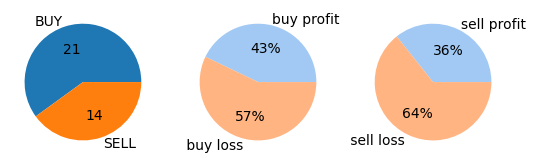

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_trade_counts(trades):
    buy_sell_counts = trades["side"].value_counts()
    #px.bar(trades["side"].value_counts(), title="Trade counts")
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    #fig.suptitle('Profit/loss trade counts')
    
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["BUY","SELL"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)
    
plot_trade_counts(trades)


In [12]:
import plotly.express as px

def plot_profit_stat(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
    px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()

    plot_profit_stat(trades)

## Trades on candlestick chart

In [13]:
from datetime import datetime
def get_last_candles():
    candle_columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_asset_volume",
                      "number_of_trades", " taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
                      "ignore"]    
    end_date=trades.open_time.max() if not trades.empty else datetime.utcnow()
    
    #end_time_millis=end_date.value//1000000
    cnt=24*60 # Number of last candles to read
    raw_candles = client.klines(symbol=symbol,
                                    interval="1m",
                                    #limit=10,
                                    limit=cnt,
                                    #endTime=end_time_millis
                               )
    df = pd.DataFrame(raw_candles, columns=candle_columns)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df.set_index("open_time", drop=False, inplace=True)
        # Convert strings to float prices
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df

def clean_candles(df):
    """ Remove outliers """
    q_low = df["low"].diff().quantile(0.1)
    q_high  = df["high"].diff().quantile(0.9)
    df=df[df["high"].diff()< q_high]
    df=df[df["low"].diff() > q_low ]
    return df

candles = get_last_candles()
candles = clean_candles(candles)
candles.tail()

,open_time,open,high,low,close,vol,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,,
2023-05-11 07:33:00,2023-05-11 07:33:00,27548.08,27548.98,27546.68,27546.68,1.75016600,2023-05-11 07:33:59.999,48213.08595545,59,0.72439300,19955.71414360,0
2023-05-11 07:34:00,2023-05-11 07:34:00,27546.68,27548.32,27542.02,27548.32,3.97333800,2023-05-11 07:34:59.999,109447.17074617,166,2.14439000,59069.28036218,0
2023-05-11 07:35:00,2023-05-11 07:35:00,27548.32,27553.22,27541.21,27541.23,2.45820000,2023-05-11 07:35:59.999,67712.59395680,131,0.68328500,18823.29651359,0
2023-05-11 07:36:00,2023-05-11 07:36:00,27541.23,27541.26,27535.72,27535.72,1.17361700,2023-05-11 07:36:59.999,32319.39911676,123,0.34500000,9500.71072182,0
2023-05-11 07:37:00,2023-05-11 07:37:00,27535.72,27535.77,27534.02,27535.72,1.32952400,2023-05-11 07:37:59.999,36608.59076172,71,0.59201900,16301.67237551,0


In [14]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def get_chart_figure(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades.open_time.isna()) & (trades.open_time > df.open_time.min())].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}, sl={trade['stop_loss_price']}, tp={trade['take_profit_price']}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    for i,trade in trades[(~trades.close_time.isna()) & (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text='close buy' if trade['side']=="BUY"  else 'close sell'
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    return fig

get_chart_figure(candles, trades).show()



## Predicted and actual low/high

In [15]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last_data(strategy):
    """ Read days from start to end from local predictions history"""
    
    def read_last(symbol: str, name: str, n: int):
        data_dir=f"./../data/{strategy}/Xy"
        file_path = sorted([f for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
        return pd.read_csv(f"{data_dir}/{file_path}", parse_dates=True, index_col="datetime").tail(n)
    n=1000
    data=read_last("BTCUSDT", "data", n)
    X=read_last("BTCUSDT", "X", n)
    y=read_last("BTCUSDT", "y", n)
    data=pd.merge(data[["symbol"]],y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
data,_,_ = read_last_data(strategy)
data.tail(100)

,symbol,bid,ask,bid_max_fut,bid_min_fut,ask_min_fut,ask_max_fut,predict_window,open_signal,cur_trade
datetime,,,,,,,,,,
2023-05-10 19:16:34.767751,BTCUSDT,27692.98,27692.99,27692.982818,27687.336839,27687.526077,27693.054229,60s,0,0
2023-05-10 19:16:34.767751,BTCUSDT,27692.98,27692.99,27692.982801,27687.336762,27687.526423,27693.054624,60s,0,0
2023-05-10 19:16:34.767751,BTCUSDT,27692.98,27692.99,27692.982815,27687.337034,27687.526218,27693.054283,60s,0,0
2023-05-10 19:16:34.767751,BTCUSDT,27692.98,27692.99,27692.982812,27687.337151,27687.526314,27693.054328,60s,0,0
2023-05-10 19:16:34.767751,BTCUSDT,27692.98,27692.99,27692.982823,27687.337095,27687.526062,27693.054093,60s,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-05-10 19:16:37.956264,BTCUSDT,27692.96,27692.97,27692.962854,27687.010317,27687.527021,27693.122118,60s,0,0
2023-05-10 19:16:37.956264,BTCUSDT,27692.96,27692.97,27692.960190,27686.975625,27687.492529,27693.103466,60s,0,0
2023-05-10 19:16:38.223079,BTCUSDT,27692.96,27692.97,27692.962854,27687.010317,27687.527021,27693.122118,60s,0,0


In [16]:

def get_predictions(data):
    """ 
    Merge predicted and real prices for analysis 
    """
    
    # Prediction window is constant, get it from last row
    predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
    predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
    predict_window=data["predict_window"].tail(1).values[0]
    real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
    real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
    real=pd.concat([real_min, real_max], axis=1)
    real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)
    merged=pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='forward')
    return merged[["bid", "ask", "bid_min_real", "bid_min_predicted", "bid_max_real", "bid_max_predicted", \
                   "ask_min_real", "ask_min_predicted", "ask_max_real", "ask_max_predicted"]]


# predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
# predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
# predict_window=data["predict_window"].tail(1).values[0]
# real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
# real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
# real=pd.concat([real_min, real_max], axis=1)
# real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)

# pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='backward')


predictions = get_predictions(data)
predictions.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-05-10 19:16:03.856807 to 2023-05-10 19:16:38.754764
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bid                1000 non-null   float64
 1   ask                1000 non-null   float64
 2   bid_min_real       1000 non-null   float64
 3   bid_min_predicted  1000 non-null   float64
 4   bid_max_real       1000 non-null   float64
 5   bid_max_predicted  1000 non-null   float64
 6   ask_min_real       1000 non-null   float64
 7   ask_min_predicted  1000 non-null   float64
 8   ask_max_real       1000 non-null   float64
 9   ask_max_predicted  1000 non-null   float64
dtypes: float64(10)
memory usage: 85.9 KB


## Prediction errors

In [17]:
def plot_prediction_err(predictions):
    df = pd.DataFrame(index=predictions.index)
    for bidask in ["bid", "ask"]:
        for maxmin in ["max", "min"]:
            prefix = f"{bidask}_{maxmin}"
            df[f"{prefix}_error"] = predictions[f"{prefix}_predicted"] - predictions[f"{prefix}_real"]
    
    px.line(df, title="Errors", markers=True).show()
    px.line(df.sum(axis=1).abs().rename("error sum"), title="Error summary", markers=True).show()
    
plot_prediction_err(predictions)

In [18]:
import pandas as pd

def get_profits(predictions: pd.DataFrame)->pd.DataFrame:
    """
    Buy, sell profit, real and predicted, for each time moment
    """
    
    profits = pd.DataFrame()
    # Profit/loss ratio to consider buy or sell
    min_ratio=2

    # Calculate possible profits for buy or sell
    profits["buy_profit_predicted"] = predictions["bid_max_predicted"] - predictions["ask"]
    profits["buy_loss_predicted"] = predictions["ask"]-predictions["bid_min_predicted"]
    profits['buy_ratio_predicted'] = np.where(profits['buy_loss_predicted'] > 0, profits['buy_profit_predicted'] / profits['buy_loss_predicted'],float('inf'))

    profits["buy_profit_real"] = predictions["bid_max_real"] - predictions["ask"]
    profits["buy_loss_real"] = predictions["ask"]-predictions["bid_min_real"]
    profits['buy_ratio_real'] = np.where(profits['buy_loss_real'] > 0, profits['buy_profit_real'] / profits['buy_loss_real'],float('inf'))


    profits["sell_profit_predicted"] = predictions["bid"] - predictions["ask_min_predicted"]
    profits["sell_loss_predicted"] = predictions["ask_max_predicted"] - predictions["bid"]
    profits['sell_ratio_predicted'] = np.where(profits['sell_loss_predicted'] > 0, profits['sell_profit_predicted'] / profits['sell_loss_predicted'],float('inf'))

    profits["sell_profit_real"] = predictions["bid"] - predictions["ask_min_real"]
    profits["sell_loss_real"] = predictions["ask_max_real"] - predictions["bid"]
    profits['sell_ratio_real'] = np.where(profits['sell_loss_real'] > 0, profits['sell_profit_real'] / profits['sell_loss_real'],float('inf'))


    profits["signal"] = np.where(profits['buy_ratio_predicted'] >= min_ratio, 1,
                                 np.where(profits["sell_ratio_predicted"]>=min_ratio, -1,0 ))

    # Calculate real profit or loss
    profits["profit_real"] = np.where(
        # If buy                             
        profits["signal"]==1,
        np.where(
            # Real movement down was inside what we predicted
            (predictions["bid_min_real"] < predictions["bid_min_predicted"]) 
            & (predictions["bid_max_real"] <= predictions["bid_max_predicted"]),
            # Take the profit
            profits["buy_profit_predicted"],
            # Or fix the loss
            -profits["buy_loss_predicted"]
        ),
        # If Sell                     
        np.where(profits["signal"] == -1,
            np.where(
                # Real movement down was inside what we predicted
                (predictions["ask_max_real"] > predictions["ask_max_predicted"]) 
                & (predictions["ask_min_real"] >= predictions["ask_max_predicted"]),
                # Take the profit
                profits["sell_profit_predicted"],
                # Or fix the loss
                -profits["sell_loss_predicted"]
            ),
            # If neither buy nor sell, return NaN
            np.nan
        )
    )

    # Fill in predicted profit
    profits["profit_predicted"]=np.where(profits["signal"] == 1, 
                                         # If buy
                                         profits["buy_profit_predicted"], 
                                        np.where(profits["signal"]==-1,
                                                # If sell
                                                profits["sell_profit_predicted"],
                                                # If neither buy not sell
                                                 np.nan))
    return profits

profits = get_profits(predictions)
pd.set_option('display.max_rows', 1000)
pd.concat([predictions,profits],axis=1).tail()
#profits.dropna().tail(100)




,bid,ask,bid_min_real,bid_min_predicted,bid_max_real,bid_max_predicted,ask_min_real,ask_min_predicted,ask_max_real,ask_max_predicted,buy_profit_predicted,buy_loss_predicted,buy_ratio_predicted,buy_profit_real,buy_loss_real,buy_ratio_real,sell_profit_predicted,sell_loss_predicted,sell_ratio_predicted,sell_profit_real,sell_loss_real,sell_ratio_real,signal,profit_real,profit_predicted
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10 19:16:37.956264,27696.58,27696.59,27692.96,27691.25991,27696.58,27696.603605,27692.97,27686.580939,27696.59,27693.986234,0.013605,5.33009,0.002552,-0.01,3.63,-0.002755,9.999061,-2.593766,inf,3.61,0.01,361.0,-1,2.593766,9.999061
2023-05-10 19:16:37.956264,27696.58,27696.59,27692.96,27691.25991,27696.58,27696.603605,27692.97,27686.580939,27696.59,27693.986234,0.013605,5.33009,0.002552,-0.01,3.63,-0.002755,9.999061,-2.593766,inf,3.61,0.01,361.0,-1,2.593766,9.999061
2023-05-10 19:16:38.223079,27696.58,27696.59,27692.96,27691.25991,27696.58,27696.603605,27692.97,27686.580939,27696.59,27693.986234,0.013605,5.33009,0.002552,-0.01,3.63,-0.002755,9.999061,-2.593766,inf,3.61,0.01,361.0,-1,2.593766,9.999061
2023-05-10 19:16:38.223079,27696.58,27696.59,27692.96,27691.25991,27696.58,27696.603605,27692.97,27686.580939,27696.59,27693.986234,0.013605,5.33009,0.002552,-0.01,3.63,-0.002755,9.999061,-2.593766,inf,3.61,0.01,361.0,-1,2.593766,9.999061
2023-05-10 19:16:38.754764,27696.58,27696.59,27692.96,27691.25991,27696.58,27696.603605,27692.97,27686.580939,27696.59,27693.986234,0.013605,5.33009,0.002552,-0.01,3.63,-0.002755,9.999061,-2.593766,inf,3.61,0.01,361.0,-1,2.593766,9.999061


In [19]:
print(f"Total prediction profit sum: {profits['profit_real'].sum()}")



Total prediction profit sum: 7666.39311790741


In [20]:
#px.line(profits[["profit_predicted", "profit_real"]], markers=True)
px.line(profits["profit_predicted"]-profits["profit_real"])

## Sharp ratio

In [21]:
sharp_ratio_df=profits[["buy_ratio_predicted", "buy_ratio_real", "sell_ratio_predicted", "sell_ratio_real"]]
sharp_ratio_df.tail()


,buy_ratio_predicted,buy_ratio_real,sell_ratio_predicted,sell_ratio_real
datetime,,,,
2023-05-10 19:16:37.956264,0.002552,-0.002755,inf,361.0
2023-05-10 19:16:37.956264,0.002552,-0.002755,inf,361.0
2023-05-10 19:16:38.223079,0.002552,-0.002755,inf,361.0
2023-05-10 19:16:38.223079,0.002552,-0.002755,inf,361.0
2023-05-10 19:16:38.754764,0.002552,-0.002755,inf,361.0


In [22]:
px.line(sharp_ratio_df[["buy_ratio_predicted", "buy_ratio_real"]], title="Buy sharp ratio")

In [23]:
px.line(sharp_ratio_df[["sell_ratio_predicted", "sell_ratio_real"]], title="Sell sharp ratio")